# Parsing of result files

First, let's read the list of container images, distributions and number of packages. TODO: clean file

In [1]:
with open('./train3.csv', 'r') as f:
    lines = f.readlines()
images = { l.split(',')[0]: (l.split(',')[1], l.split(',')[3]) for l in lines[1:]}

In [2]:
#images = { x: images[x] for x in images if x != 'poldracklab/fmriprep:unstable' and x != 'bids/ndmg' }
images
# image: (distro, n_packages)

{'gkiar/onevoxel:v0.3.0rc2': ('alpine:3.7.1', '71'),
 'bids/rshrf:1.0.1': ('alpine:3.8.4', '35'),
 'gkiar/mask2boundary:v0.1.0': ('alpine:3.9.0', '61'),
 'bids/broccoli:v1.0.0': ('centos:6', '253'),
 'mcin/docker-fsl:latest': ('centos:7', '145'),
 'bids/nipypelines:0.3.0': ('debian:8', '157'),
 'bids/baracus': ('ubuntu:14.04', '218'),
 'bids/rs_signal_extract:0.1': ('ubuntu:16.04', '241'),
 'bids/antscorticalthickness:v2.2.0-1': ('ubuntu:17.04', '291'),
 'bids/afni_proc': ('ubuntu:17.10', '277'),
 'mcin/ica-aroma:latest': ('centos:7', '159'),
 'bids/magetbrain': ('ubuntu:18.04', '167'),
 'mcin/qeeg:latest': ('centos:7', '171'),
 'bt5e/ants:latest': ('centos:7', '188'),
 'bigdatalabteam/hcp-prefreesurfer:exec-centos7-fslbuild-centos5-latest': ('centos:7',
  '240'),
 'bigdatalabteam/hcp-prefreesurfer:exec-centos7.freesurferbuild-centos4-latest': ('centos:7',
  '254'),
 'bids/brainiak-srm': ('ubuntu:16.04', '258'),
 'gkiar/dwipreproc_fsl-5.0.11_minified': ('ubuntu:16.04', '269'),
 'bids/m

In [3]:
len(images)

38

We have 38 container images to analyze. TODO: how about Singularity images? TODO: check numbers in paper

## Anchore

Let's now parse the vulnerabilities detected by Anchore, and summarize them in a DataFrame:

In [4]:
import os.path as op
data_dir = './Data/Anchore-New-Results'

anchore_files = {}

# Find vulnerability file by image name
for d in images:
    
    prefix, image = d.split('/')
    
    # Check if image is from BIDS or Boutiques (heuristic)
    if prefix.upper() != 'BIDS' and prefix != 'poldracklab':
        prefix = 'Boutiques'
    else:
        prefix = 'BIDS'
    if ':' in image:
        image_name, version = image.split(':')
    else:
        image_name = image
        version = 'latest'
    
    # Handle ndmg manually
    if d == 'bids/ndmg:v0.1.0':
        prefix = 'Boutiques'
        image_name = 'ndmg'
        version = 'v0.1.0'
    
    # Handle fmriprep manually
    if d == 'poldracklab/fmriprep:1.2.3':
        prefix = 'Boutiques'
        image_name = 'fmriprep'
        version = '1.2.3'
    
    # Handle hcp-prefreesurfer manually
    if image_name == 'hcp-prefreesurfer':
        if version == 'exec-centos7-fslbuild-centos5-latest':
            image_name = 'hcp-prefreesurfer1'
        if version == 'exec-centos7.freesurferbuild-centos4-latest':
            image_name = 'hcp-prefreesurfer2'
    
    file_name = op.join(data_dir, prefix, image_name) + '.csv'
    if not op.isfile(file_name):
        print(f'File not found: {file_name}')

    anchore_files[d] = (file_name, images[d][0], images[d][1])

In [5]:
anchore_files['poldracklab/fmriprep:1.2.3']
# Each entry in anchore_files is a triple: (file_name, container_image, n_packages)

('./Data/Anchore-New-Results/Boutiques/fmriprep.csv', 'ubuntu:16.04', '441')

Let's also read the number of vulnerabilities after minification and update:

In [6]:
    # Get total vulnerabilities after minification
    with open('./Results_after_minification.csv', 'r') as f:
        lines = f.readlines()

    minifications = [ line.split(',') for line in lines[1:]]
    def get_after_minification(packages, vulnerabilities):
        for l in minifications:
            # TODO: check discrepancy in the number of vulnerabilities in Results_after_update2.csv
            if int(l[0]) == packages:# and int(l[1]) ==  vulnerabilities:
                return int(l[2].strip())

In [7]:
    # Get total vulnerabilities after update
    with open('./Results_after_update2.csv', 'r') as f:
        lines = f.readlines()

    updates = [ line.split(',') for line in lines[1:]]
    def get_after_updates(packages, vulnerabilities):
        for l in updates:
            # TODO: check discrepancy in the number of vulnerabilities in Results_after_update2.csv
            if int(l[0]) == packages:# and int(l[1]) ==  vulnerabilities:
                return int(l[2].strip())

In [8]:
    # Get total vulnerabilities after update AND minification
    with open('./Results_after_updateANDminification.csv', 'r') as f:
        lines = f.readlines()

    boths = [ line.split(',') for line in lines[1:]]
    def get_after_both(packages, vulnerabilities):
        for l in boths:
            if int(l[0]) == packages:# and int(l[1]) ==  vulnerabilities:
                return int(l[1].strip())

We're now ready to build our summary DataFrame:

In [9]:
import pandas as pd
import shlex

# Colors that will be used to represent distributions in Figures
# Keep this here as it's used in various functions
distro_colors = {
        'ubuntu': 'xkcd:orangered',
        'debian': 'xkcd:teal',
        'centos': 'xkcd:blue',
        'alpine': 'xkcd:lightblue'
}
    
def get_summary(dist_files, get_n_unique_vul, severity = True, update_and_minif=True):
    
    # Columns of the dataframe
    df_columns = ['Abbrv', 'Image', 'Distribution', 'Version', 'Color', # image and parameters
                  'Negligible', 'Low', 'Medium', 'High', 'Critical', # vulnerabilities by severity
                  'Total', 'Total_after_update', 'Total_after_minification', 'Total_after_both', 'File'] # total vulnerabilities
        
    summary = pd.DataFrame(columns=df_columns)
    
    for i, image in enumerate(dist_files):
        filename = dist_files[image][0]
        with open(filename, 'r') as f:
            lines = f.readlines()
        
        if severity:
            negligible = get_n_unique_vul('Negligible', lines)
            low = get_n_unique_vul('Low', lines)
            medium = get_n_unique_vul('Medium', lines)
            high = get_n_unique_vul('High', lines)
            critical = get_n_unique_vul('Critical', lines)
            total = negligible + low + medium + high + critical
        else:
            negligible = None
            low = None
            medium = None
            high = None
            critical = None
            total = get_n_unique_vul('All', lines)
        
        # Total number of packages
        packages = int(dist_files[image][2])
        
        # Define abbreviations to be used in figures
        abbrv = image.split('/')[1]
        if ':' in abbrv:
            abbrv = abbrv.split(':')[0]
        collisions = ['ndmg', 'hcp-prefreesurfer', 'fmriprep']
        if abbrv in collisions:
            abbrv += str(i % 2)
        ascii = 65 + i
        if ascii > 90:
            ascii += 6
        abbrv = chr(ascii) + " "
        
        # Get vulnerabilities after update
        after_update = None
        after_minification = None
        after_both = None
        if update_and_minif:
            after_update = get_after_updates(packages, total)
            after_minification = get_after_minification(packages, total)
            after_both = get_after_both(packages, total)
    
            if image == 'bids/afni_proc': # npackage-based calculations doesn't work here
                after_update = None
                after_minification = None
                both = None
            
        version = images[image][0].split(':')[1]
        distribution = images[image][0].split(':')[0]
        summary = summary.append({
            'Image': image,
            'Abbrv': abbrv,
            'Distribution': distribution,
            'Version': version,
            'Color': distro_colors[distribution],
            'Packages': packages,
            'Negligible': negligible,
            'Low': low,
            'Medium': medium,
            'High': high,
            'Critical': critical,
            'Total': total,
            'Total_after_update': after_update,
            'Total_after_minification': after_minification,
            'Total_after_both': after_both,
            'File': filename
        }, ignore_index=True)
    summary = summary.sort_values('Total', ascending=False)
    return summary

In [10]:
def get_n_unique_vul_anchore(status, lines):
    lines = [ shlex.split(line) for line in lines ][1:]
    cves = [x[0] for x in lines if x[2] == status]
    return len(set(cves))

anchore_summary = get_summary(anchore_files, get_n_unique_vul_anchore)
anchore_summary

Abbrv                                              Image Distribution  \
36    k                                 bids/hyperalignment       ubuntu   
37    l                                           bids/niak       ubuntu   
33    h                    bids/fibredensityandcrosssection       ubuntu   
31    f                                    bids/ndmg:v0.1.0       ubuntu   
32    g                                           bids/ndmg       ubuntu   
35    j                                 bids/oppni:v0.7.0-1       ubuntu   
16    Q                                   bids/brainiak-srm       ubuntu   
30    e                               bids/tracula:v6.0.0-4       ubuntu   
7     H                          bids/rs_signal_extract:0.1       ubuntu   
29    d                                        bids/example       ubuntu   
34    i                                bids/cpac:v1.0.1a_22       ubuntu   
18    S                             bids/mindboggle:0.0.4-1       debian   
5     F                              bids/nipypelines:0.3.0       debian   
26    a                          poldracklab/fmriprep:1.2.3       ubuntu   
27    b                       poldracklab/fmriprep:unstable       ubuntu   
25    Z                        bids/hcppipelines:v3.17.0-18       debian   
28    c                                 bids/dparsf:v4.3.12       ubuntu   
24    Y                            poldracklab/mriqc:0.15.0       ubuntu   
17    R                gkiar/dwipreproc_fsl-5.0.11_minified       ubuntu   
20    U                                     bids/freesurfer       ubuntu   
8     I                 bids/antscorticalthickness:v2.2.0-1       ubuntu   
21    V                             bids/mrtrix3_connectome       ubuntu   
22    W                                            bids/spm       ubuntu   
23    X                                      bids/aa:v0.2.0       ubuntu   
6     G                                        bids/baracus       ubuntu   
13    N                                    bt5e/ants:latest       centos   
11    L                                     bids/magetbrain       ubuntu   
3     D                                bids/broccoli:v1.0.0       centos   
10    K                               mcin/ica-aroma:latest       centos   
4     E                              mcin/docker-fsl:latest       centos   
15    P   bigdatalabteam/hcp-prefreesurfer:exec-centos7....       centos   
14    O   bigdatalabteam/hcp-prefreesurfer:exec-centos7-...       centos   
9     J                                      bids/afni_proc       ubuntu   
19    T                              camarasu/creaphase:0.3       centos   
12    M                                    mcin/qeeg:latest       centos   
2     C                          gkiar/mask2boundary:v0.1.0       alpine   
1     B                                    bids/rshrf:1.0.1       alpine   
0     A                            gkiar/onevoxel:v0.3.0rc2       alpine   

   Version           Color Negligible  Low Medium High Critical Total  \
36   16.04  xkcd:orangered        100  594    971   50        1  1716   
37   16.04  xkcd:orangered        106  557    783   35        1  1482   
33   14.04  xkcd:orangered         79  427    545   34        1  1086   
31   14.04  xkcd:orangered         79  387    448   20        0   934   
32   14.04  xkcd:orangered         79  387    448   20        0   934   
35   14.04  xkcd:orangered         76  371    438   27        1   913   
16   16.04  xkcd:orangered         54  365    431   46        1   897   
30   14.04  xkcd:orangered         76  360    415   22        1   874   
7    16.04  xkcd:orangered         61  378    383   44        1   867   
29   14.04  xkcd:orangered         76  358    385   19        0   838   
34   16.04  xkcd:orangered         56  348    276   18        0   698   
18       8       xkcd:teal        165   61    279  159        0   664   
5        8       xkcd:teal        130   72    266  162        0   630   
26   16.04  xkcd

In [11]:
len(anchore_summary)

38

In [12]:
anchore_summary['Total'].mean()

467.8421052631579

In [13]:
anchore_summary['Total'].median()

372.0

## Ideas about attacks

To have a better idea of the type of attacks that could exploit these vulnerabilities, let's list the critical vulnerabilities:

In [14]:
# List unique critical CVEs
import shlex
file_names = [anchore_files[image][0] for image in images]
critical = []
for file_name in file_names:
    with open(file_name, 'r') as f:
        lines = f.readlines()
    lines = [ shlex.split(line) for line in lines ][1:]
    critical += [(l[0], l[4]) for l in lines if l[2] == 'Critical']
critical = set(critical)
print(critical)
print(len(critical))

{('CVE-2017-5754', 'http://people.ubuntu.com/~ubuntu-security/cve/CVE-2017-5754'), ('RHSA-2015:1981', 'https://access.redhat.com/errata/RHSA-2015:1981'), ('RHSA-2016:0176', 'https://access.redhat.com/errata/RHSA-2016:0176'), ('RHSA-2016:0370', 'https://access.redhat.com/errata/RHSA-2016:0370'), ('RHSA-2017:1100', 'https://access.redhat.com/errata/RHSA-2017:1100')}
5


## Clair

In [15]:
import os 

clair_files = {}
for image in images:
    clair_files[image] = (anchore_files[image][0].replace('Anchore', 'Clair').replace('csv', 'txt'),
                          anchore_files[image][1],
                          anchore_files[image][2] )

for f in clair_files:
    if not os.path.isfile(clair_files[f][0]):
        print(f'Missing file: {clair_files[f][0]}')

In [16]:
def get_n_unique_vul_clair(status, lines):
    cves = [x for x in lines if status in x]
    return len(set(cves))

clair_summary = get_summary(clair_files, get_n_unique_vul_clair, severity=True, update_and_minif=False)
clair_summary

Abbrv                                              Image Distribution  \
37    l                                           bids/niak       ubuntu   
36    k                                 bids/hyperalignment       ubuntu   
18    S                             bids/mindboggle:0.0.4-1       debian   
5     F                              bids/nipypelines:0.3.0       debian   
25    Z                        bids/hcppipelines:v3.17.0-18       debian   
33    h                    bids/fibredensityandcrosssection       ubuntu   
31    f                                    bids/ndmg:v0.1.0       ubuntu   
32    g                                           bids/ndmg       ubuntu   
28    c                                 bids/dparsf:v4.3.12       ubuntu   
35    j                                 bids/oppni:v0.7.0-1       ubuntu   
30    e                               bids/tracula:v6.0.0-4       ubuntu   
29    d                                        bids/example       ubuntu   
34    i                                bids/cpac:v1.0.1a_22       ubuntu   
16    Q                                   bids/brainiak-srm       ubuntu   
26    a                          poldracklab/fmriprep:1.2.3       ubuntu   
7     H                          bids/rs_signal_extract:0.1       ubuntu   
27    b                       poldracklab/fmriprep:unstable       ubuntu   
24    Y                            poldracklab/mriqc:0.15.0       ubuntu   
13    N                                    bt5e/ants:latest       centos   
17    R                gkiar/dwipreproc_fsl-5.0.11_minified       ubuntu   
22    W                                            bids/spm       ubuntu   
23    X                                      bids/aa:v0.2.0       ubuntu   
6     G                                        bids/baracus       ubuntu   
20    U                                     bids/freesurfer       ubuntu   
21    V                             bids/mrtrix3_connectome       ubuntu   
14    O   bigdatalabteam/hcp-prefreesurfer:exec-centos7-...       centos   
15    P   bigdatalabteam/hcp-prefreesurfer:exec-centos7....       centos   
10    K                               mcin/ica-aroma:latest       centos   
4     E                              mcin/docker-fsl:latest       centos   
3     D                                bids/broccoli:v1.0.0       centos   
11    L                                     bids/magetbrain       ubuntu   
19    T                              camarasu/creaphase:0.3       centos   
12    M                                    mcin/qeeg:latest       centos   
8     I                 bids/antscorticalthickness:v2.2.0-1       ubuntu   
9     J                                      bids/afni_proc       ubuntu   
2     C                          gkiar/mask2boundary:v0.1.0       alpine   
1     B                                    bids/rshrf:1.0.1       alpine   
0     A                            gkiar/onevoxel:v0.3.0rc2       alpine   

   Version           Color Negligible  Low Medium High Critical Total  \
37   16.04  xkcd:orangered        103  713    755   13        0  1584   
36   16.04  xkcd:orangered         76  488    779   19        0  1362   
18       8       xkcd:teal        177  174    413  226        0   990   
5        8       xkcd:teal        144  164    379  218        0   905   
25       8       xkcd:teal        193  172    354  153        0   872   
33   14.04  xkcd:orangered         62  349    450   10        0   871   
31   14.04  xkcd:orangered         66  306    406   10        0   788   
32   14.04  xkcd:orangered         66  306    405   10        0   787   
28   14.04  xkcd:orangered         65  295    390    7        0   757   
35   14.04  xkcd:orangered         60  282    365    9        0   716   
30   14.04  xkcd:orangered         63  282    345    8        0   698   
29   14.04  xkcd:orangered         63  282    343    8        0   696   
34   16.04  xkcd:orangered         34  296    205    8        0   543   
16   16.04  xkcd

## Vuls

In [17]:
vuls_files = {}

for image in images:
    if 'ubuntu:17' in images[image][0] or 'centos' in images[image][0]: 
        continue # vuls doesn't support ubuntu 17
    file_name = anchore_files[image][0].replace('Anchore', 'Vuls')
    if os.path.isfile(file_name):
        vuls_files[image] = ( file_name, images[image][0], images[image][1] )
    else:
        print(f'Missing file: {file_name}')

In [18]:
def get_n_unique_vul_vuls(severity, lines):
    if severity != 'All':
        raise(f'Vuls doesnt have info about severity {severity}')
    return len(lines)

vuls_summary = get_summary(vuls_files, get_n_unique_vul_vuls, severity=False, update_and_minif=False)
vuls_summary

Abbrv                                 Image Distribution Version  \
26    a                    bids/hyperalignment       ubuntu   16.04   
27    b                              bids/niak       ubuntu   16.04   
23    X       bids/fibredensityandcrosssection       ubuntu   14.04   
22    W                              bids/ndmg       ubuntu   14.04   
21    V                       bids/ndmg:v0.1.0       ubuntu   14.04   
18    S                    bids/dparsf:v4.3.12       ubuntu   14.04   
25    Z                    bids/oppni:v0.7.0-1       ubuntu   14.04   
20    U                  bids/tracula:v6.0.0-4       ubuntu   14.04   
19    T                           bids/example       ubuntu   14.04   
15    P           bids/hcppipelines:v3.17.0-18       debian       8   
9     J                bids/mindboggle:0.0.4-1       debian       8   
24    Y                   bids/cpac:v1.0.1a_22       ubuntu   16.04   
7     H                      bids/brainiak-srm       ubuntu   16.04   
5     F             bids/rs_signal_extract:0.1       ubuntu   16.04   
3     D                 bids/nipypelines:0.3.0       debian       8   
16    Q             poldracklab/fmriprep:1.2.3       ubuntu   16.04   
17    R          poldracklab/fmriprep:unstable       ubuntu   16.04   
14    O               poldracklab/mriqc:0.15.0       ubuntu   16.04   
8     I   gkiar/dwipreproc_fsl-5.0.11_minified       ubuntu   16.04   
12    M                               bids/spm       ubuntu   14.04   
13    N                         bids/aa:v0.2.0       ubuntu   14.04   
4     E                           bids/baracus       ubuntu   14.04   
10    K                        bids/freesurfer       ubuntu   14.04   
11    L                bids/mrtrix3_connectome       ubuntu   18.04   
6     G                        bids/magetbrain       ubuntu   18.04   
2     C             gkiar/mask2boundary:v0.1.0       alpine   3.9.0   
1     B                       bids/rshrf:1.0.1       alpine   3.8.4   
0     A               gkiar/onevoxel:v0.3.0rc2       alpine   3.7.1   

             Color Negligible   Low Medium  High Critical Total  \
26  xkcd:orangered       None  None   None  None     None  1433   
27  xkcd:orangered       None  None   None  None     None  1420   
23  xkcd:orangered       None  None   None  None     None   868   
22  xkcd:orangered       None  None   None  None     None   782   
21  xkcd:orangered       None  None   None  None     None   782   
18  xkcd:orangered       None  None   None  None     None   757   
25  xkcd:orangered       None  None   None  None     None   723   
20  xkcd:orangered       None  None   None  None     None   683   
19  xkcd:orangered       None  None   None  None     None   683   
15       xkcd:teal       None  None   None  None     None   620   
9        xkcd:teal       None  None   None  None     None   569   
24  xkcd:orangered       None  None   None  None     None   535   
7   xkcd:orangered       None  None   None  None     None   503   
5   xkcd:orangered       None  None   None  None     None   473   
3        xkcd:teal       None  None   None  None     None   451   
16  xkcd:orangered       None  None   None  None     None   447   
17  xkcd:orangered       None  None   None  None     None   393   
14  xkcd:orangered       None  None   None  None     None   332   
8   xkcd:orangered       None  None   None  None     None   263   
12  xkcd:orangered       None  None   None  None     None   235   
13  xkcd:orangered       None  None   None  None     None   233   
4   xkcd:orangered       None  None   None  None     None   216   
10  xkcd:orangered       None  None   None  None     None   192   
11  xkcd:orangered       None  None   None  None     None   158   
6   xkcd:orangered       None  None   None  None     None   126   
2   xkcd:lightblue       None  None   None  None     None    11   
1   xkcd:lightblue       None  None   None  None     None     3   
0   xkcd:lightblue       None  None   None  None     None     2   


# Figures

## Vulnerabilities overview

In [19]:
def vul_plot(df, ax, severities=True):
   
    # Bar plot
    
    height=0.9
    color = df['Color']
    
    if severities:
        from numpy import zeros
        cumulatives = zeros(len(df))
        critical_color = 'red'
        statuses = [ 'Negligible', 'Low', 'Medium', 'High', 'Critical']
        for i, status in enumerate(statuses):
            values = df[status].to_numpy()
            alpha = (i+1)/(len(statuses))
            if status == 'Critical':
                color = critical_color
            ax.barh(df['Abbrv'], values, height=height, label=status, left=cumulatives,
                color=color, alpha=alpha)
            if status == 'Critical': # add text label
                for i, value in enumerate(values):
                    if value != 0:
                        pos_x = cumulatives[i] + value + 10
                        pos_y = i + height/4
                        ax.text(pos_x, pos_y, f'({value})', color=color, fontsize=label_size)
    #         for i, value in enumerate(values):
    #             # Value labels
    #             pos_x = cumulatives[i] + value/2 - 20
    #             pos_y = i + height/4
    #             if alpha <= 0.5:
    #                 color = 'black'
    #             else:
    #                 color = 'white'
    #             if value >= 50:
    #                 ax.text(pos_x, pos_y, value, color=color, fontsize=label_size)
    
            cumulatives = cumulatives + values
    else:
        ax.barh(df['Abbrv'], df['Total'].to_numpy(), height=height, label='Total',
                color=color, alpha=0.75)
    
    # Legends
    
    import matplotlib.patches as mpatches
    color_labels = {distro_colors[d]: d for d in set(df['Distribution'])}
    patches = [ mpatches.Patch(color=x, label=color_labels[x].title()) for x in color_labels]
    legend1 = ax.legend(handles=patches, bbox_to_anchor=(1, 1), ncol=1, loc='lower left',
                        fontsize=label_size, title='OS distribution')
    if severities: # Add severity legend
        patches = []
        for i in range(len(statuses)):
            alpha = (i+1)/len(statuses)
            color = (0, 0, 0, alpha)
            if i == 4:
                color = critical_color
            label = statuses[i]
            if label == 'Critical':
                label += ' (n)'
            patches += [ mpatches.Patch(color=color, label=label)]
    
        # Add the second legend (this removes the first one)
        ax.legend(handles=patches, bbox_to_anchor=(0.15, 1), ncol=5, loc='lower left',
                 fontsize=label_size, title='Severity')
        ax.legend_.set_frame_on(False)
    
        ax.tick_params(axis="x")
        ax.set_xlabel('Number of vulnerabilities')
        ax.set_ylabel('Container image')
    
        # Add the first legend back
        legend1.set_frame_on(False)
        ax.add_artist(legend1)
    
    # Figure layout
    ax.invert_yaxis()
    ax.set_frame_on(False)
    ax.set_axis_on()
    ax.set_axisbelow(True)

    ax.xaxis.grid()
    ax.xaxis.set_ticks([0, 500, 1000, 1500])
    ax.xaxis.set_ticks_position('bottom')
    ax.set_ylim(len(df)-height/2, -height/2)
    ax.set_xlim(0, 1750)

## Anchore

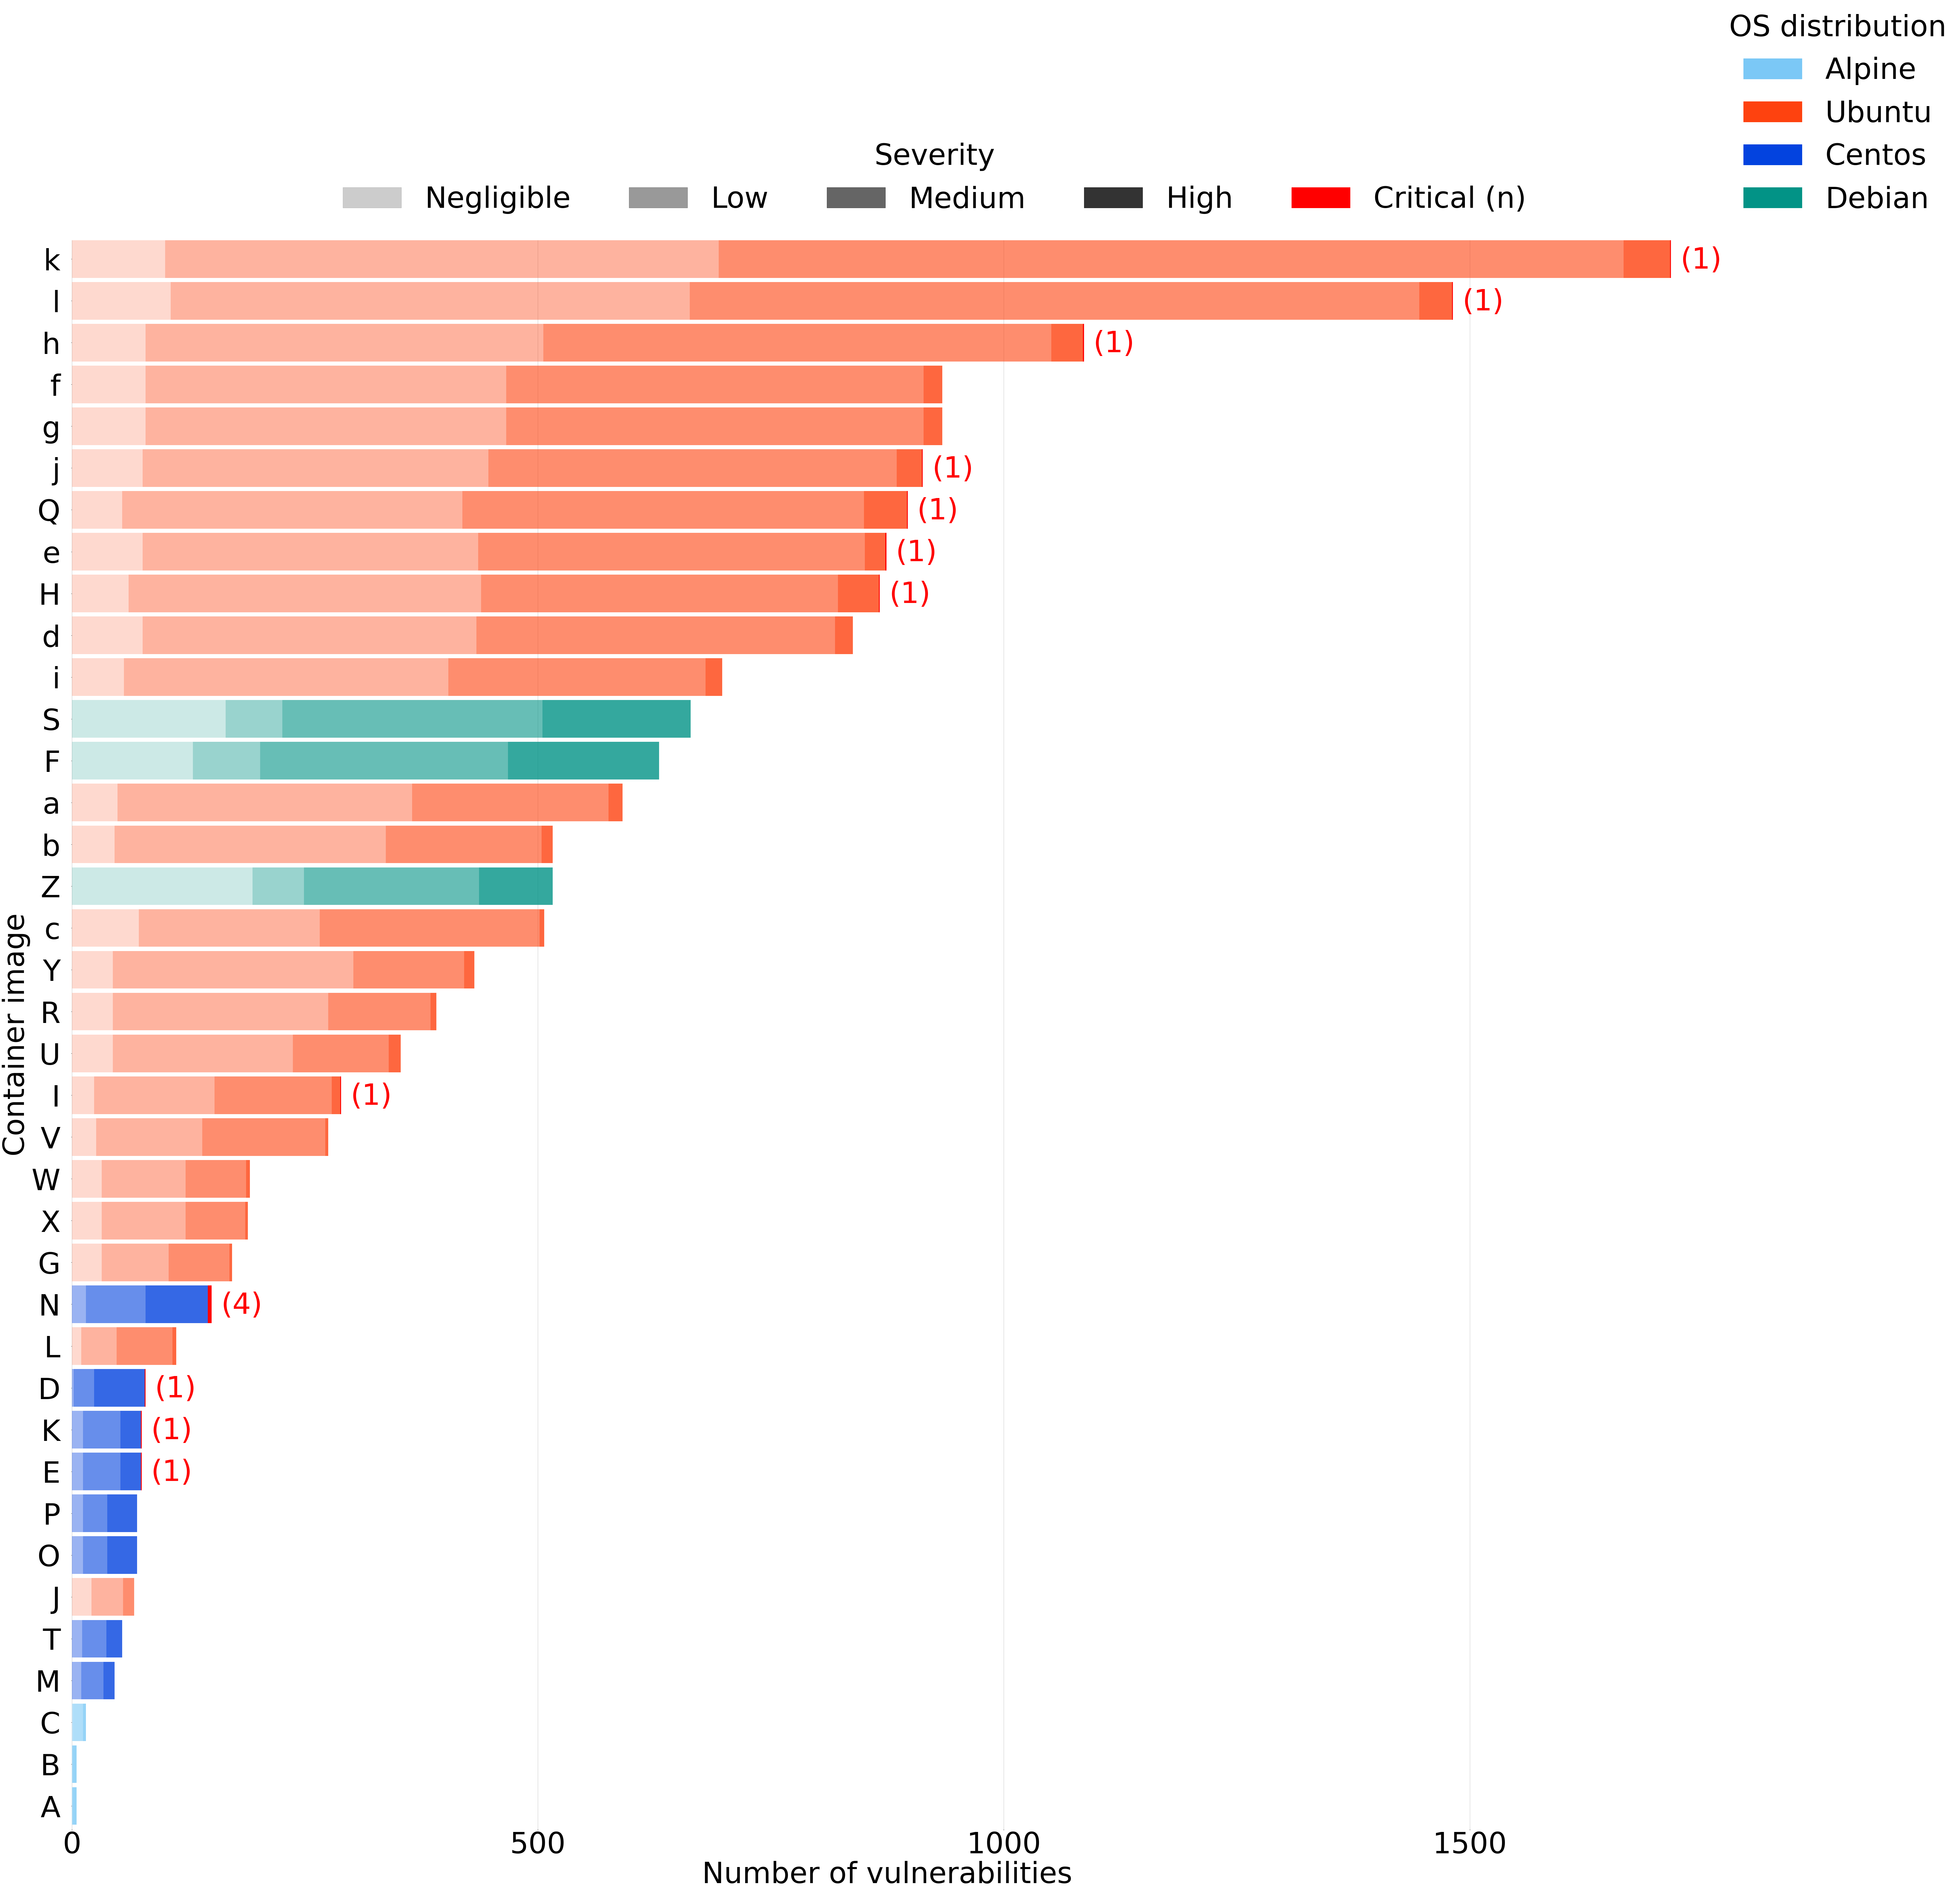

In [20]:
import matplotlib
from matplotlib import pyplot as plt

# Define font size
label_size = 100
font = {'size': label_size}
matplotlib.rc('font', **font)

# Increaes figure size
fig, ax = plt.subplots(figsize=(100, 100))
vul_plot(anchore_summary, ax)


plt.savefig('./Figures/by_status_anchore.pdf', bbox_inches="tight")
plt.show()

## Clair

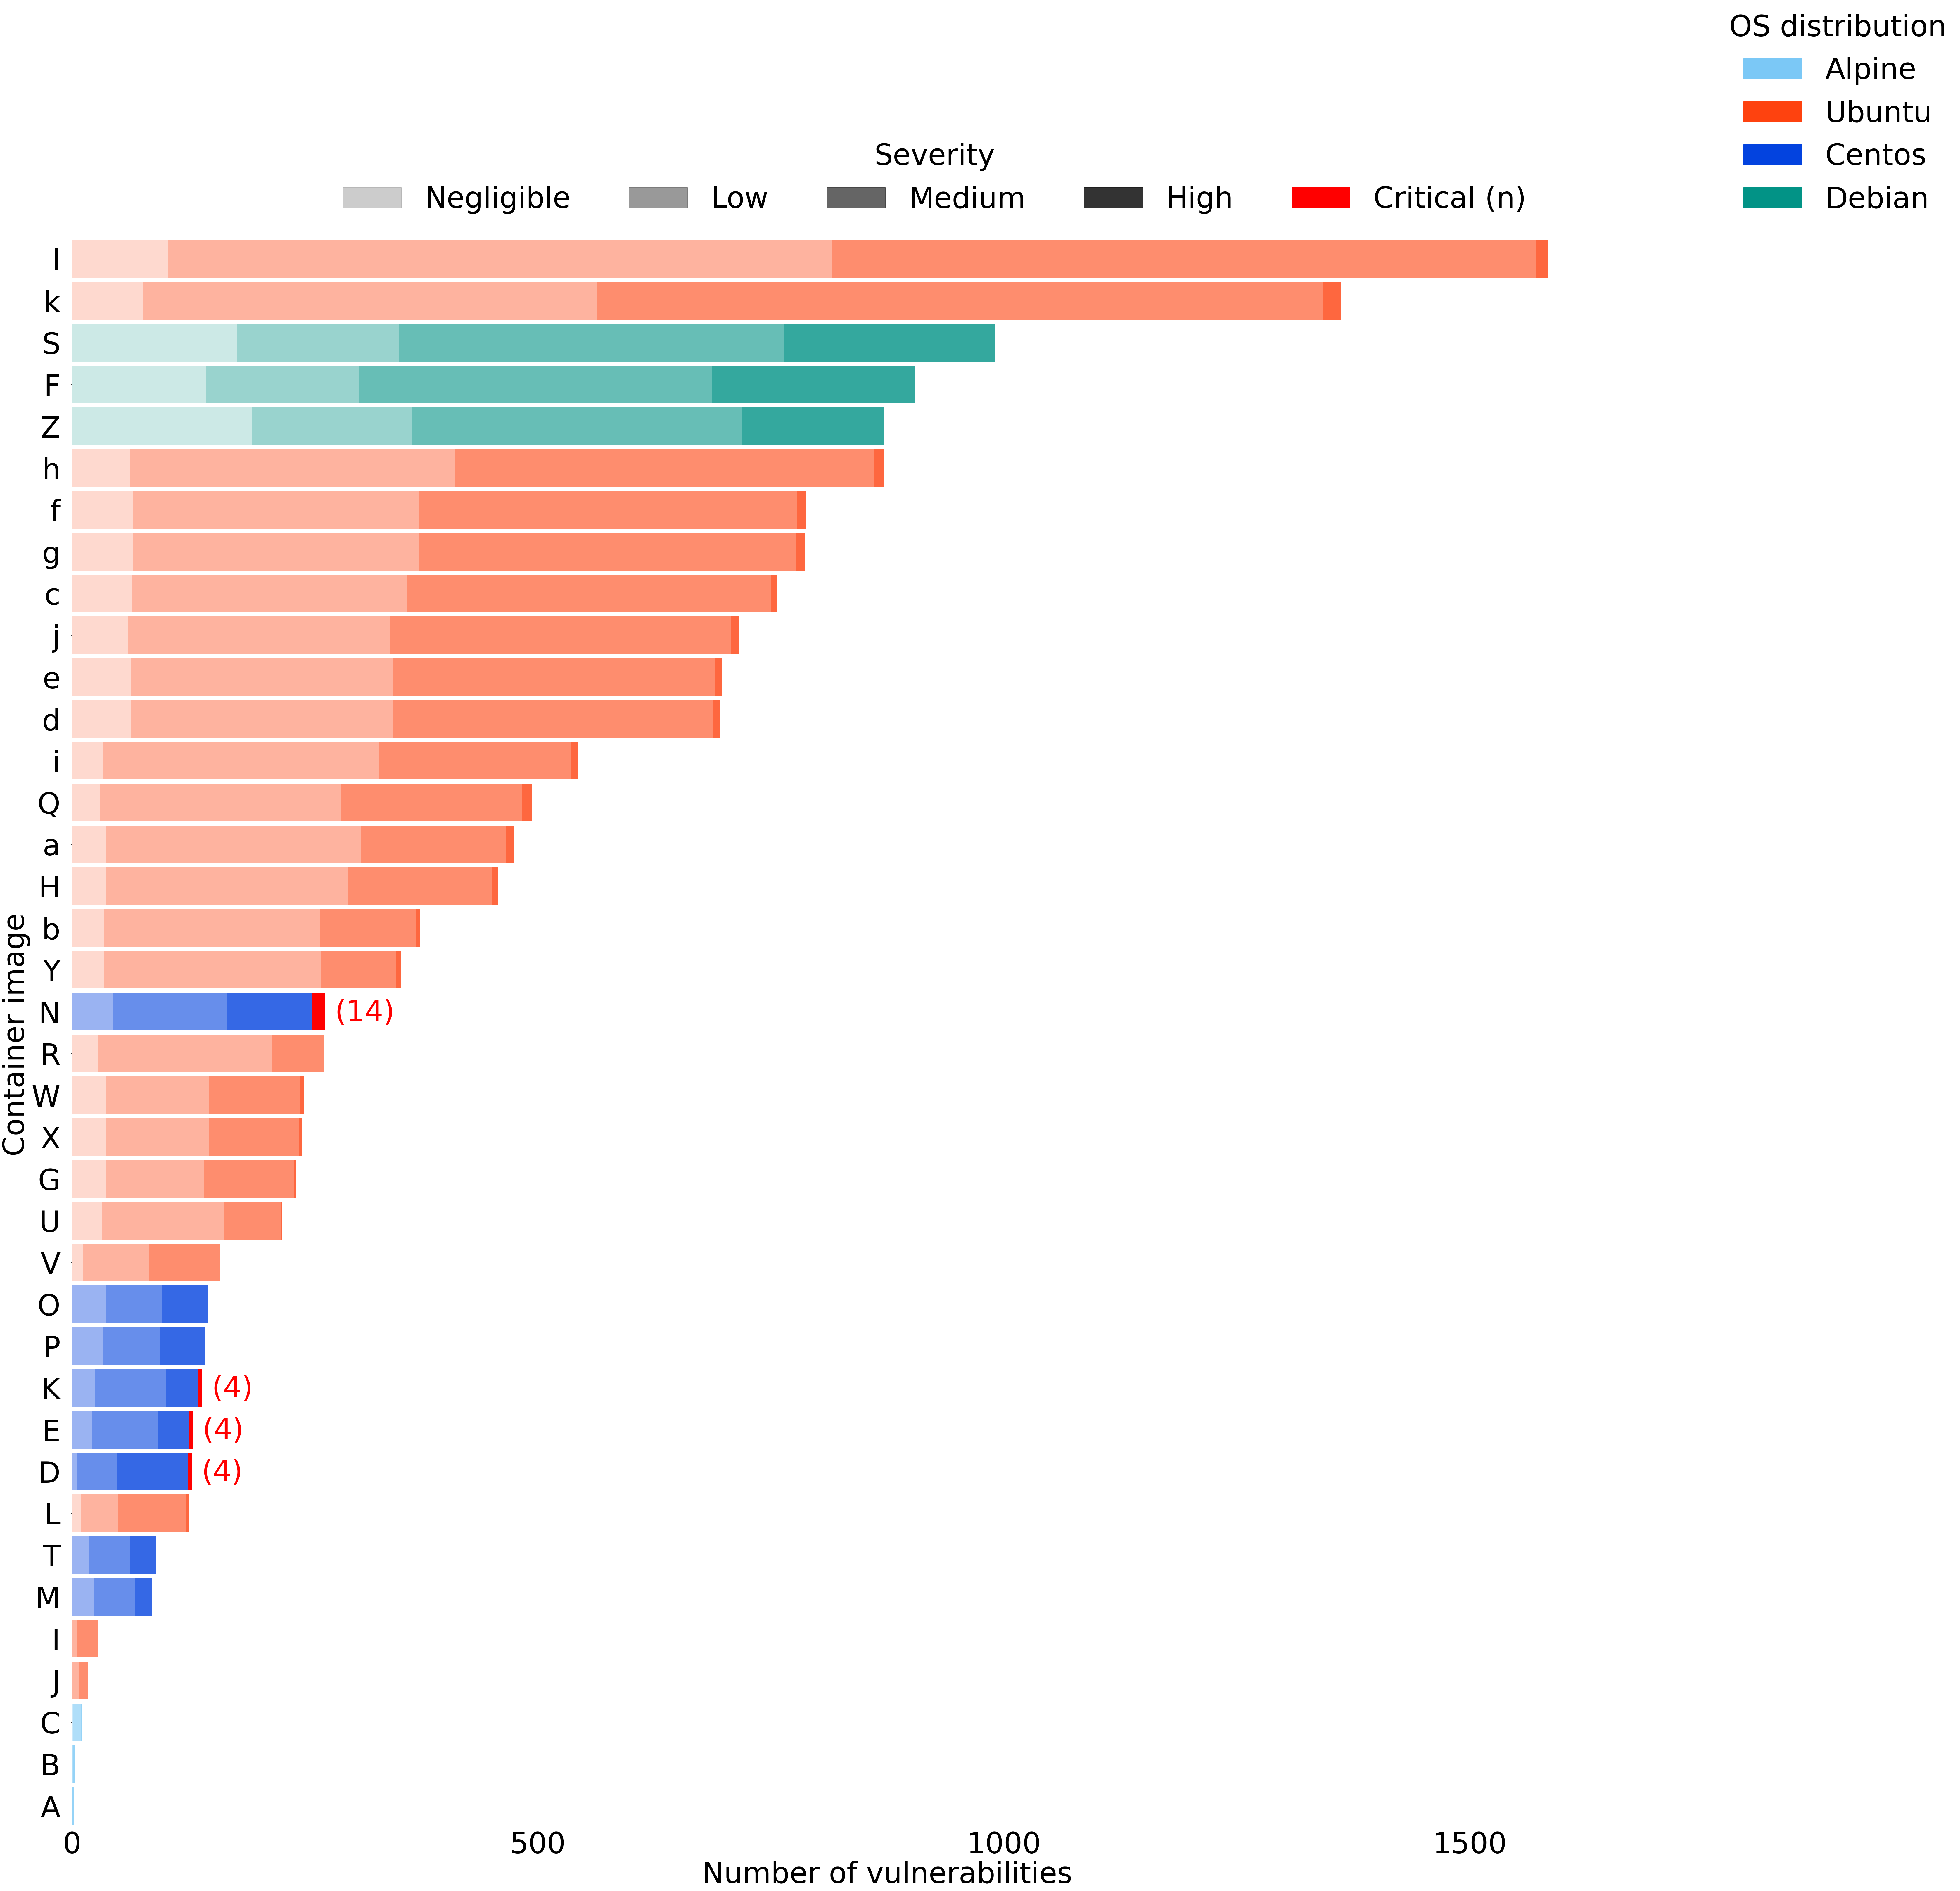

In [21]:
import matplotlib
from matplotlib import pyplot as plt

# Define font size
label_size = 100
font = {'size': label_size}
matplotlib.rc('font', **font)

# Increaes figure size
fig, ax = plt.subplots(figsize=(100, 100))
vul_plot(clair_summary, ax)


plt.savefig('./Figures/by_status_clair.pdf', bbox_inches="tight")
plt.show()

## Vuls

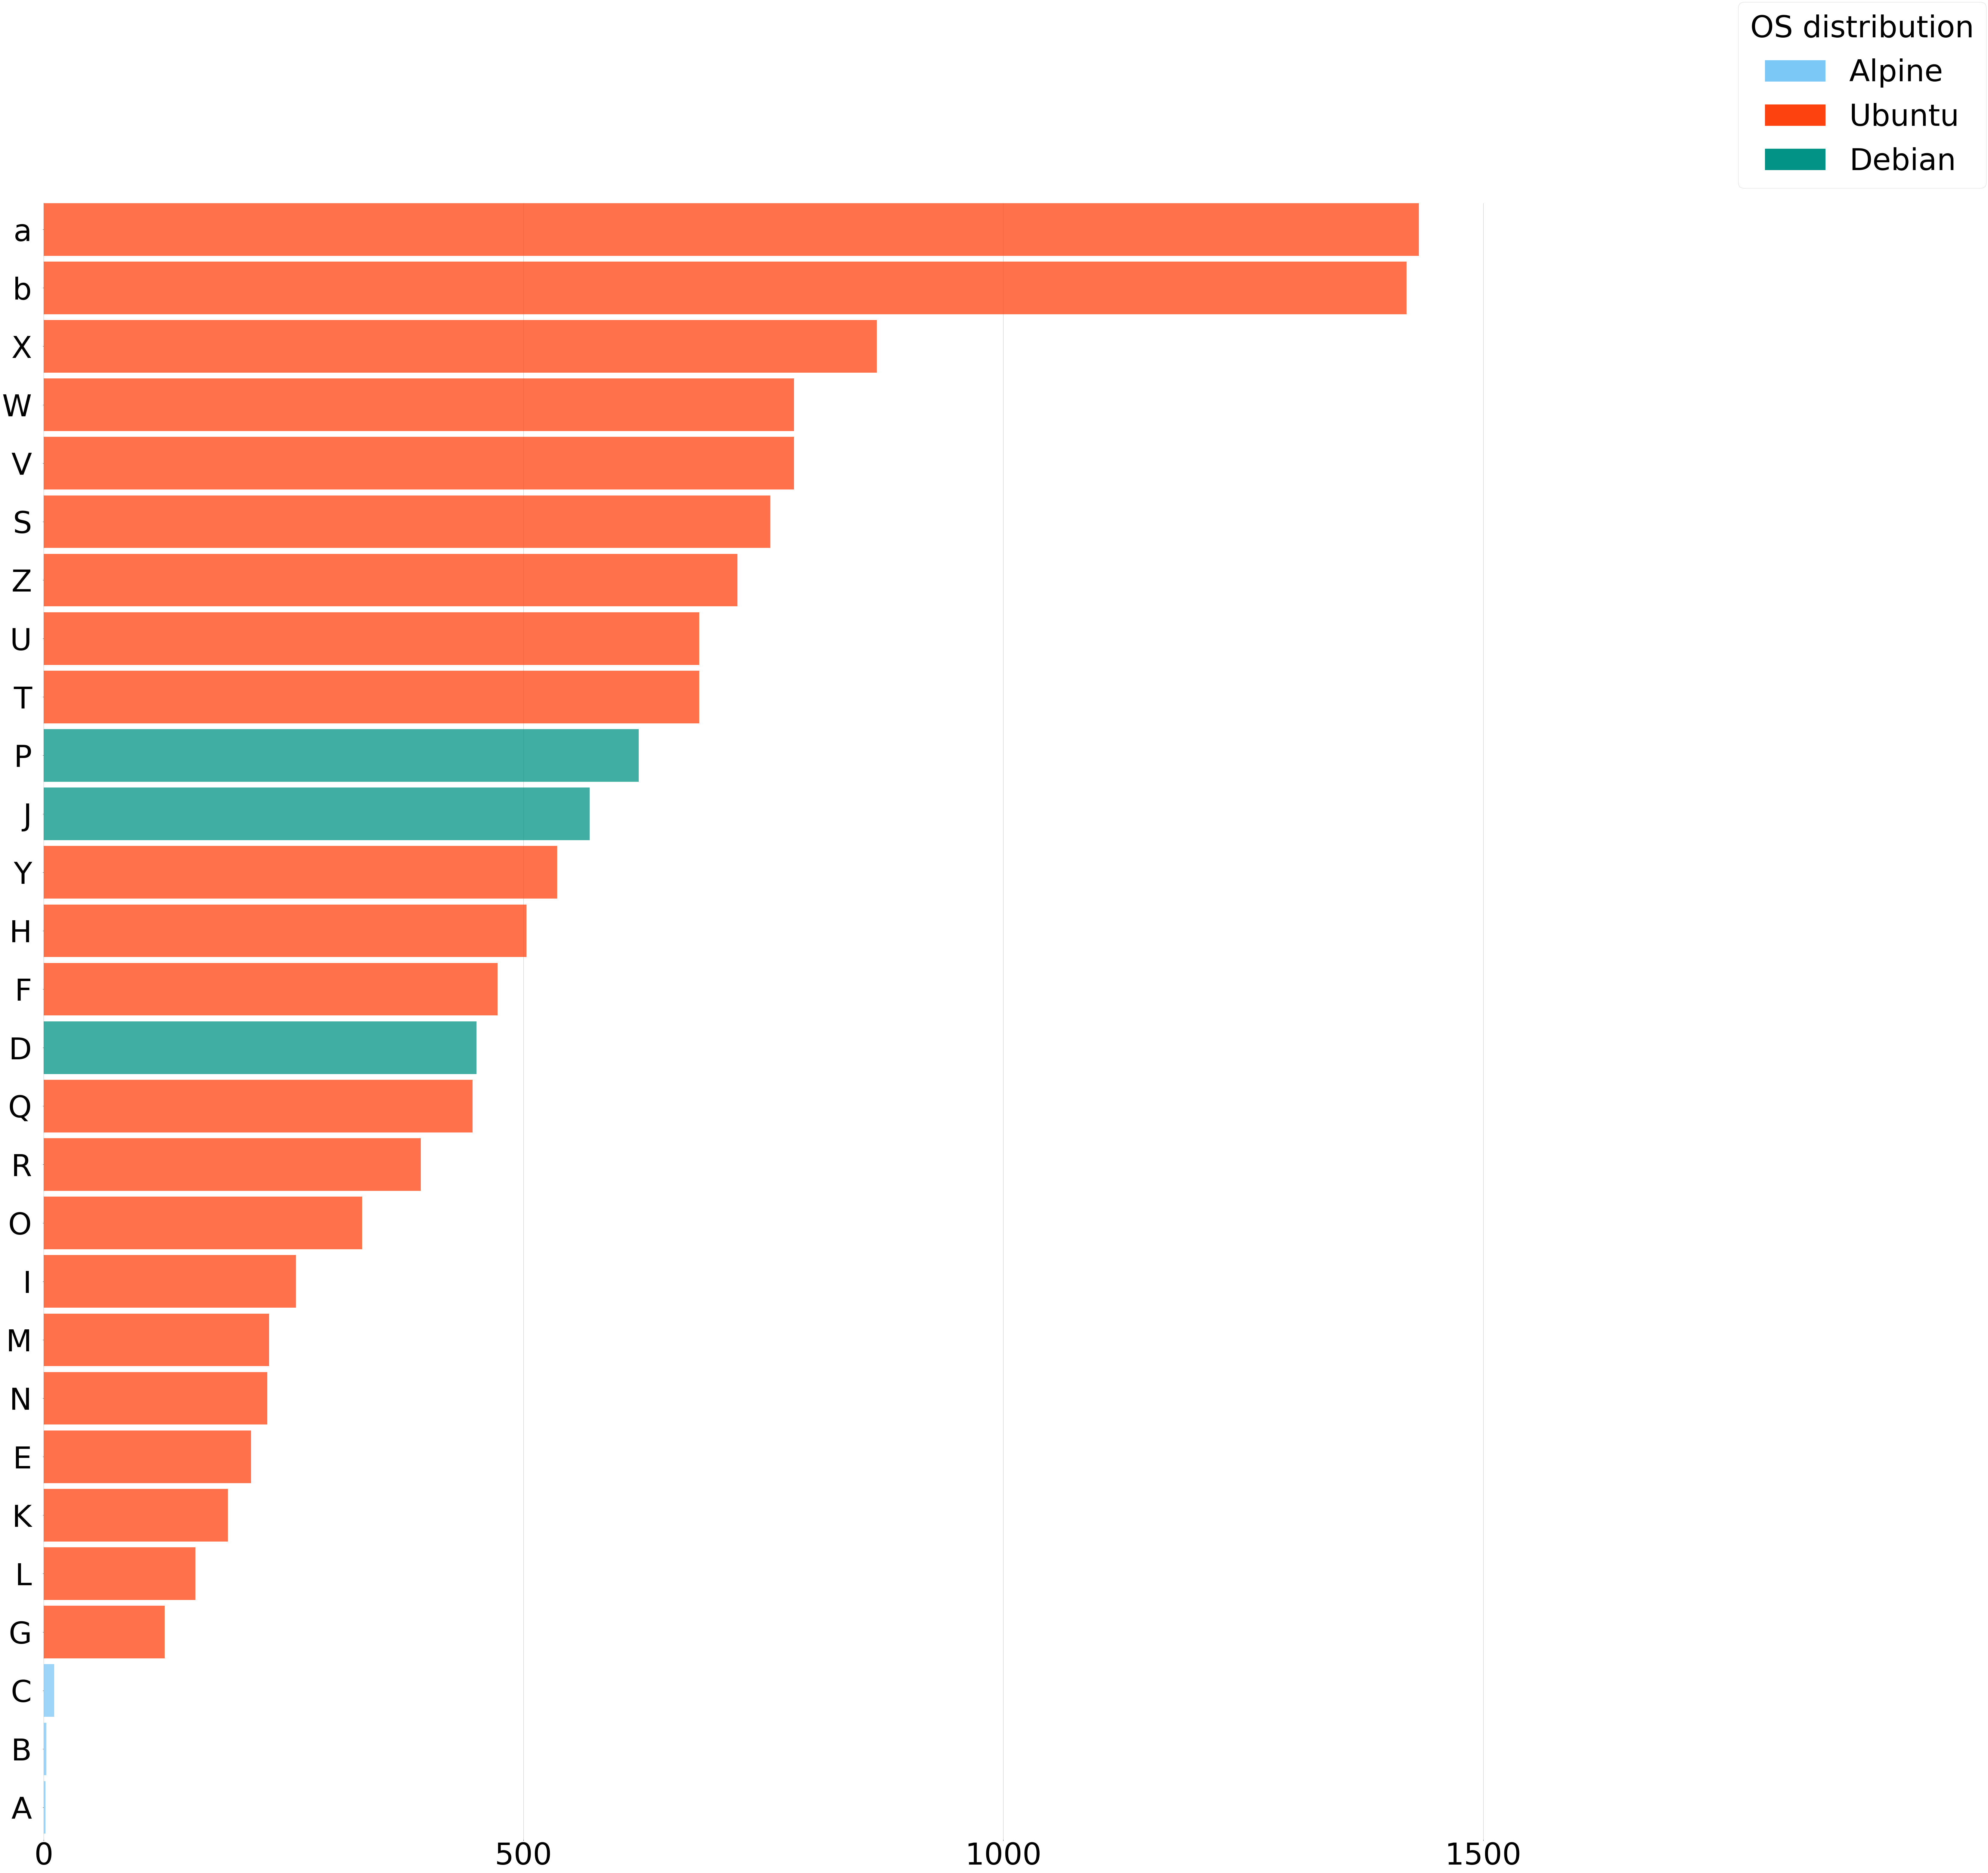

In [22]:
import matplotlib
from matplotlib import pyplot as plt

# Define font size
label_size = 100
font = {'size': label_size}
matplotlib.rc('font', **font)

# Increaes figure size
fig, ax = plt.subplots(figsize=(100, 100))
vul_plot(vuls_summary, ax, severities=False)


plt.savefig('./Figures/by_status_vuls.pdf', bbox_inches="tight")
plt.show()

## Vulnerabilities by number of packages, before and after update

In [23]:
def update_plot(df_summary, ax, ay):
    
    import scipy.stats
    import numpy as np
    size = 10000
    packages = df_summary['Packages'].to_numpy()
    total = df_summary['Total'].to_numpy().astype(np.float)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(packages, total)
    print(f'Before update: p={p_value}')
    ax.plot(packages, intercept + slope*packages, color='black', linewidth=3)
    ax.scatter(df_summary['Packages'], df_summary['Total'],
               s=size, color=df_summary['Color'], alpha=0.75, marker='o')
    ax.text(700, 1200, f'y={round(slope,1)}x-{abs(round(intercept,1))}\nr={round(r_value,2)}')

    df1 = df_summary[df_summary.Total_after_update >= 0 ] # filters None
    packages = df1['Packages'].to_numpy()
    total = df1['Total_after_update'].to_numpy().astype(np.float)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(packages, total)
    print(f'After update: p={p_value}')
    ay.plot(packages, intercept + slope*packages, color='black', linewidth=3)
    ay.scatter(df_summary['Packages'], df_summary['Total_after_update'],
               s=size, color=df_summary['Color'], alpha=0.75, marker='o')
    ay.text(700, 500, f'y={round(slope,1)}x-{abs(round(intercept,1))}\nr={round(r_value,2)}')

    ymin = -50
    ymax = 1750
    xmin = 0
    xmax = 900
    for a in [ax, ay]:
        a.set_ylim(ymin, ymax)
        a.set_xlim(xmin, xmax)
        a.set_xlabel('Number of packages')

    ax.set_title('Before update')
    ax.set_ylabel('Number of vulnerabilities')
    ay.set_title('After update')


In [24]:
# Increaes figure size
fig, (ax, ay) = plt.subplots(1, 2, figsize=(200, 100))
update_plot(anchore_summary, ax, ay)
plt.savefig('./Figures/update.pdf', bbox_inches="tight")
plt.show()

Before update: p=7.904925765646309e-11
After update: p=2.0033332887070155e-08


## Vulnerabilities after minification

In [25]:
def minif_plot(df_summary, ax):
    
    from numpy import arange
    
    df1 = df_summary[df_summary.Total_after_both >= 0][df_summary.Total_after_update >= 0] # filters None
    width=0.3
    
    ax.invert_yaxis()
    ax.barh(arange(5), df1['Total'], width, color=df1['Color'], alpha=0.1)
    ax.barh(arange(5)+width, df1['Total'], width, color=df1['Color'], alpha=0.1)
    ax.barh(arange(5)+width*2, df1['Total'], width, color=df1['Color'], alpha=0.1)

    ax.barh(arange(5), df1['Total_after_update'], width, color=df1['Color'],  alpha=0.25)
    ax.barh(arange(5)+width, df1['Total_after_minification'], width, color=df1['Color'], alpha=0.5)
    ax.barh(arange(5)+2*width, df1['Total_after_both'], width, color=df1['Color'], alpha=0.75)

    operations = ['None', 'Update', 'Minification', 'Update & Minification']
    import matplotlib.patches as mpatches
    patches = []
    for i in range(4):
        if i == 0:
            alpha = 0.1
        else:
            alpha = i/4
        patches += [ mpatches.Patch(color=(0, 0, 0, alpha), label=operations[i])]

    # Add the second legend (this removes the first one)
    ax.legend(handles=patches, bbox_to_anchor=(0.15, 1), ncol=5, loc='lower left', fontsize=label_size,
              title='Operation applied')
    ax.legend_.set_frame_on(False)

    ax.set_yticklabels(df1['Abbrv'])
    ax.set_yticks(width+arange(5))

    ax.set_frame_on(False)
    
    ax.xaxis.grid()
    ax.xaxis.set_ticks([0, 500, 1000, 1500])
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xlim(0, 1750)

    ax.set_ylabel('Container image')
    ax.set_xlabel('Number of vulnerabilities')

<ipython-input-25-7ebe570546e5>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = df_summary[df_summary.Total_after_both >= 0][df_summary.Total_after_update >= 0] # filters None
<ipython-input-25-7ebe570546e5>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(df1['Abbrv'])


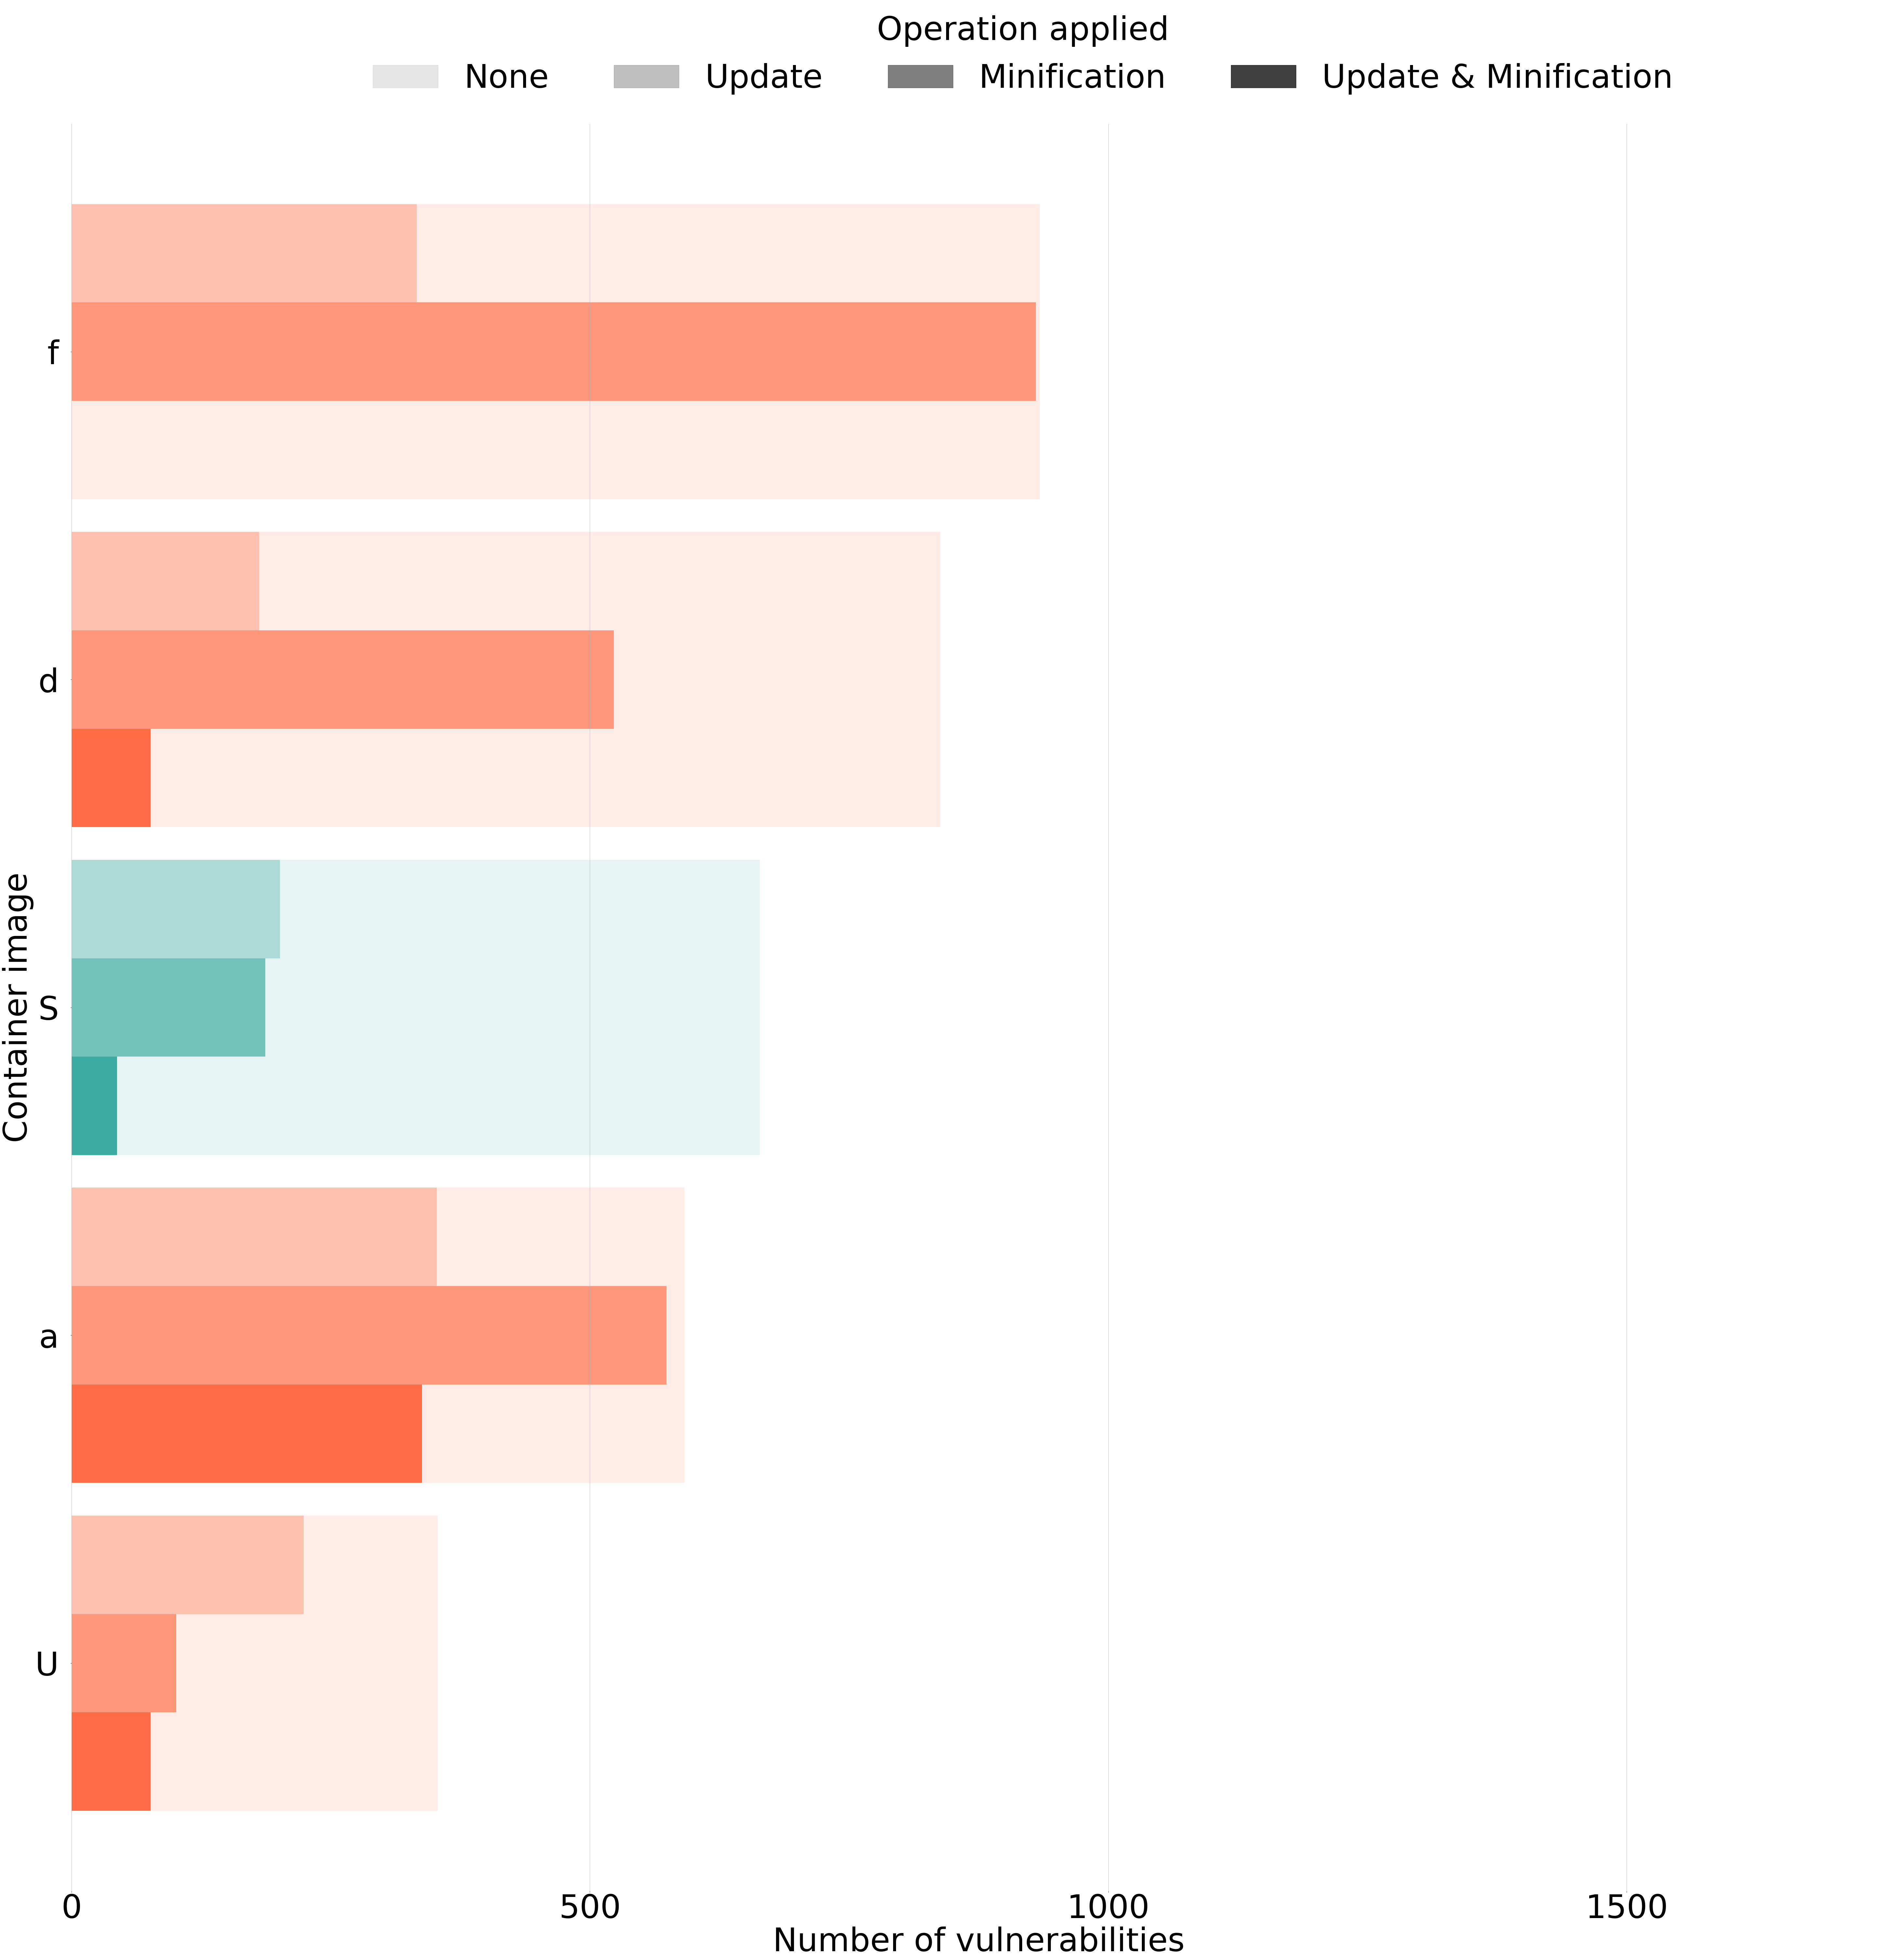

In [26]:
# Increaes figure size
fig, ax = plt.subplots(figsize=(100,100))

minif_plot(anchore_summary, ax)
plt.savefig('./Figures/update_and_minif.pdf', bbox_inches="tight")
plt.show()

## Putting all the figures together

In [27]:
from matplotlib import pyplot as plt
from numpy import zeros

# Define font size
label_size = 100
font = {'size': label_size}
matplotlib.rc('font', **font)

# Increaes figure size
fig, axs = plt.subplots(2, 2, figsize=(200,200))

label = [ 'A', 'B', 'C', 'D']
for i, ax in enumerate((axs[0,0], axs[0,1], axs[1,0], axs[1,1])):
    offset = 1.1
    ax.text(0, offset, label[i], transform=ax.transAxes,
          fontsize=200, fontweight='bold', va='top', ha='right')


vul_plot(anchore_summary, axs[0,0])
minif_plot(anchore_summary, axs[0, 1])
update_plot(anchore_summary, axs[1,0], axs[1,1])
plt.savefig('./Figures/results.pdf', bbox_inches="tight")
plt.show()

<ipython-input-25-7ebe570546e5>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = df_summary[df_summary.Total_after_both >= 0][df_summary.Total_after_update >= 0] # filters None
<ipython-input-25-7ebe570546e5>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(df1['Abbrv'])


Before update: p=7.904925765646309e-11
After update: p=2.0033332887070155e-08


# Comparison between scanners

## Venn diagram

In [28]:
severities = [ 'Negligible', 'Low', 'Medium', 'High', 'Critical']

common_images = [x for x in vuls_files] # Vuls is the most restrictive scanner

# For each scanner, list vulnerabilities founds by image
vul_clair = {}
vul_anchore = {}
vul_vuls = {}

for image in common_images: # pick only images that were processed by the 3 scanners
    clair_file = clair_files[image][0]
    anchore_file = anchore_files[image][0]
    vuls_file = vuls_files[image][0]
    # Fill clair vulnerabilities
    with open(clair_file, 'r') as f:
        lines = f.readlines()
    for l in lines[1:]:
        for s in severities:
            if s in l:
                if not image in vul_clair:
                    vul_clair[image] = []
                vul_clair[image] += [ l.split('|')[2].replace(s, '').strip() ]
    vul_clair[image] = set(vul_clair[image])
    # Fill anchore vulnerabilities
    with open(anchore_file, 'r') as f:
        lines = f.readlines()
    lines = [ shlex.split(line) for line in lines ][1:]
    vul_anchore[image] = set([ l[0] for l in lines[1:]])
    # Fill vuls vulnerabilities
    with open(vuls_file, 'r') as f:
        lines = f.readlines()
    vul_vuls[image] = set([ l.strip() for l in lines])

In [29]:
# Return variabilities in each region of the Venn diagram, for a given image
# Regions are numbered from top to bottom and from left to right
def region_1(image):
    return vul_anchore[image].difference(vul_clair[image]).difference(vul_vuls[image])
def region_2(image):
    return vul_anchore[image].difference(vul_vuls[image]).intersection(vul_clair[image])
def region_3(image):
    return vul_clair[image].difference(vul_anchore[image]).difference(vul_vuls[image])
def region_4(image):
    return vul_anchore[image].difference(vul_clair[image]).intersection(vul_vuls[image])
def region_5(image):
    return vul_anchore[image].intersection(vul_clair[image]).intersection(vul_vuls[image])
def region_6(image):
    return vul_vuls[image].difference(vul_anchore[image]).intersection(vul_clair[image])
def region_7(image):
    return vul_vuls[image].difference(vul_anchore[image]).difference(vul_clair[image])

# Compute sums of intersections, among all images
n_r_1 = sum([len(region_1(image)) for image in vuls_files])
n_r_2 = sum([len(region_2(image)) for image in vuls_files])
n_r_3 = sum([len(region_3(image)) for image in vuls_files])
n_r_4 = sum([len(region_4(image)) for image in vuls_files])
n_r_5 = sum([len(region_5(image)) for image in vuls_files])
n_r_6 = sum([len(region_6(image)) for image in vuls_files])
n_r_7 = sum([len(region_7(image)) for image in vuls_files])


# print Jaccard coefficients
d_anchore_clair = (n_r_2 + n_r_5)/(n_r_2 + n_r_5 + n_r_1 + n_r_3 + n_r_4 + n_r_6)
d_anchore_vuls = (n_r_4 + n_r_5)/(n_r_4 + n_r_5 + n_r_1 + n_r_2 + n_r_7 + n_r_6)
d_vuls_clair = (n_r_5 + n_r_6)/(n_r_5 + n_r_6 + n_r_2 + n_r_3 + n_r_4 + n_r_7)
print(f'Jaccard(Anchore,Clair)={round(d_anchore_clair, 2)}')
print(f'Jaccard(Anchore,Vuls)={round(d_anchore_vuls, 2)}')
print(f'Jaccard(Vuls, Clair)={round(d_vuls_clair, 2)}')


Jaccard(Anchore,Clair)=0.59
Jaccard(Anchore,Vuls)=0.59
Jaccard(Vuls, Clair)=0.83


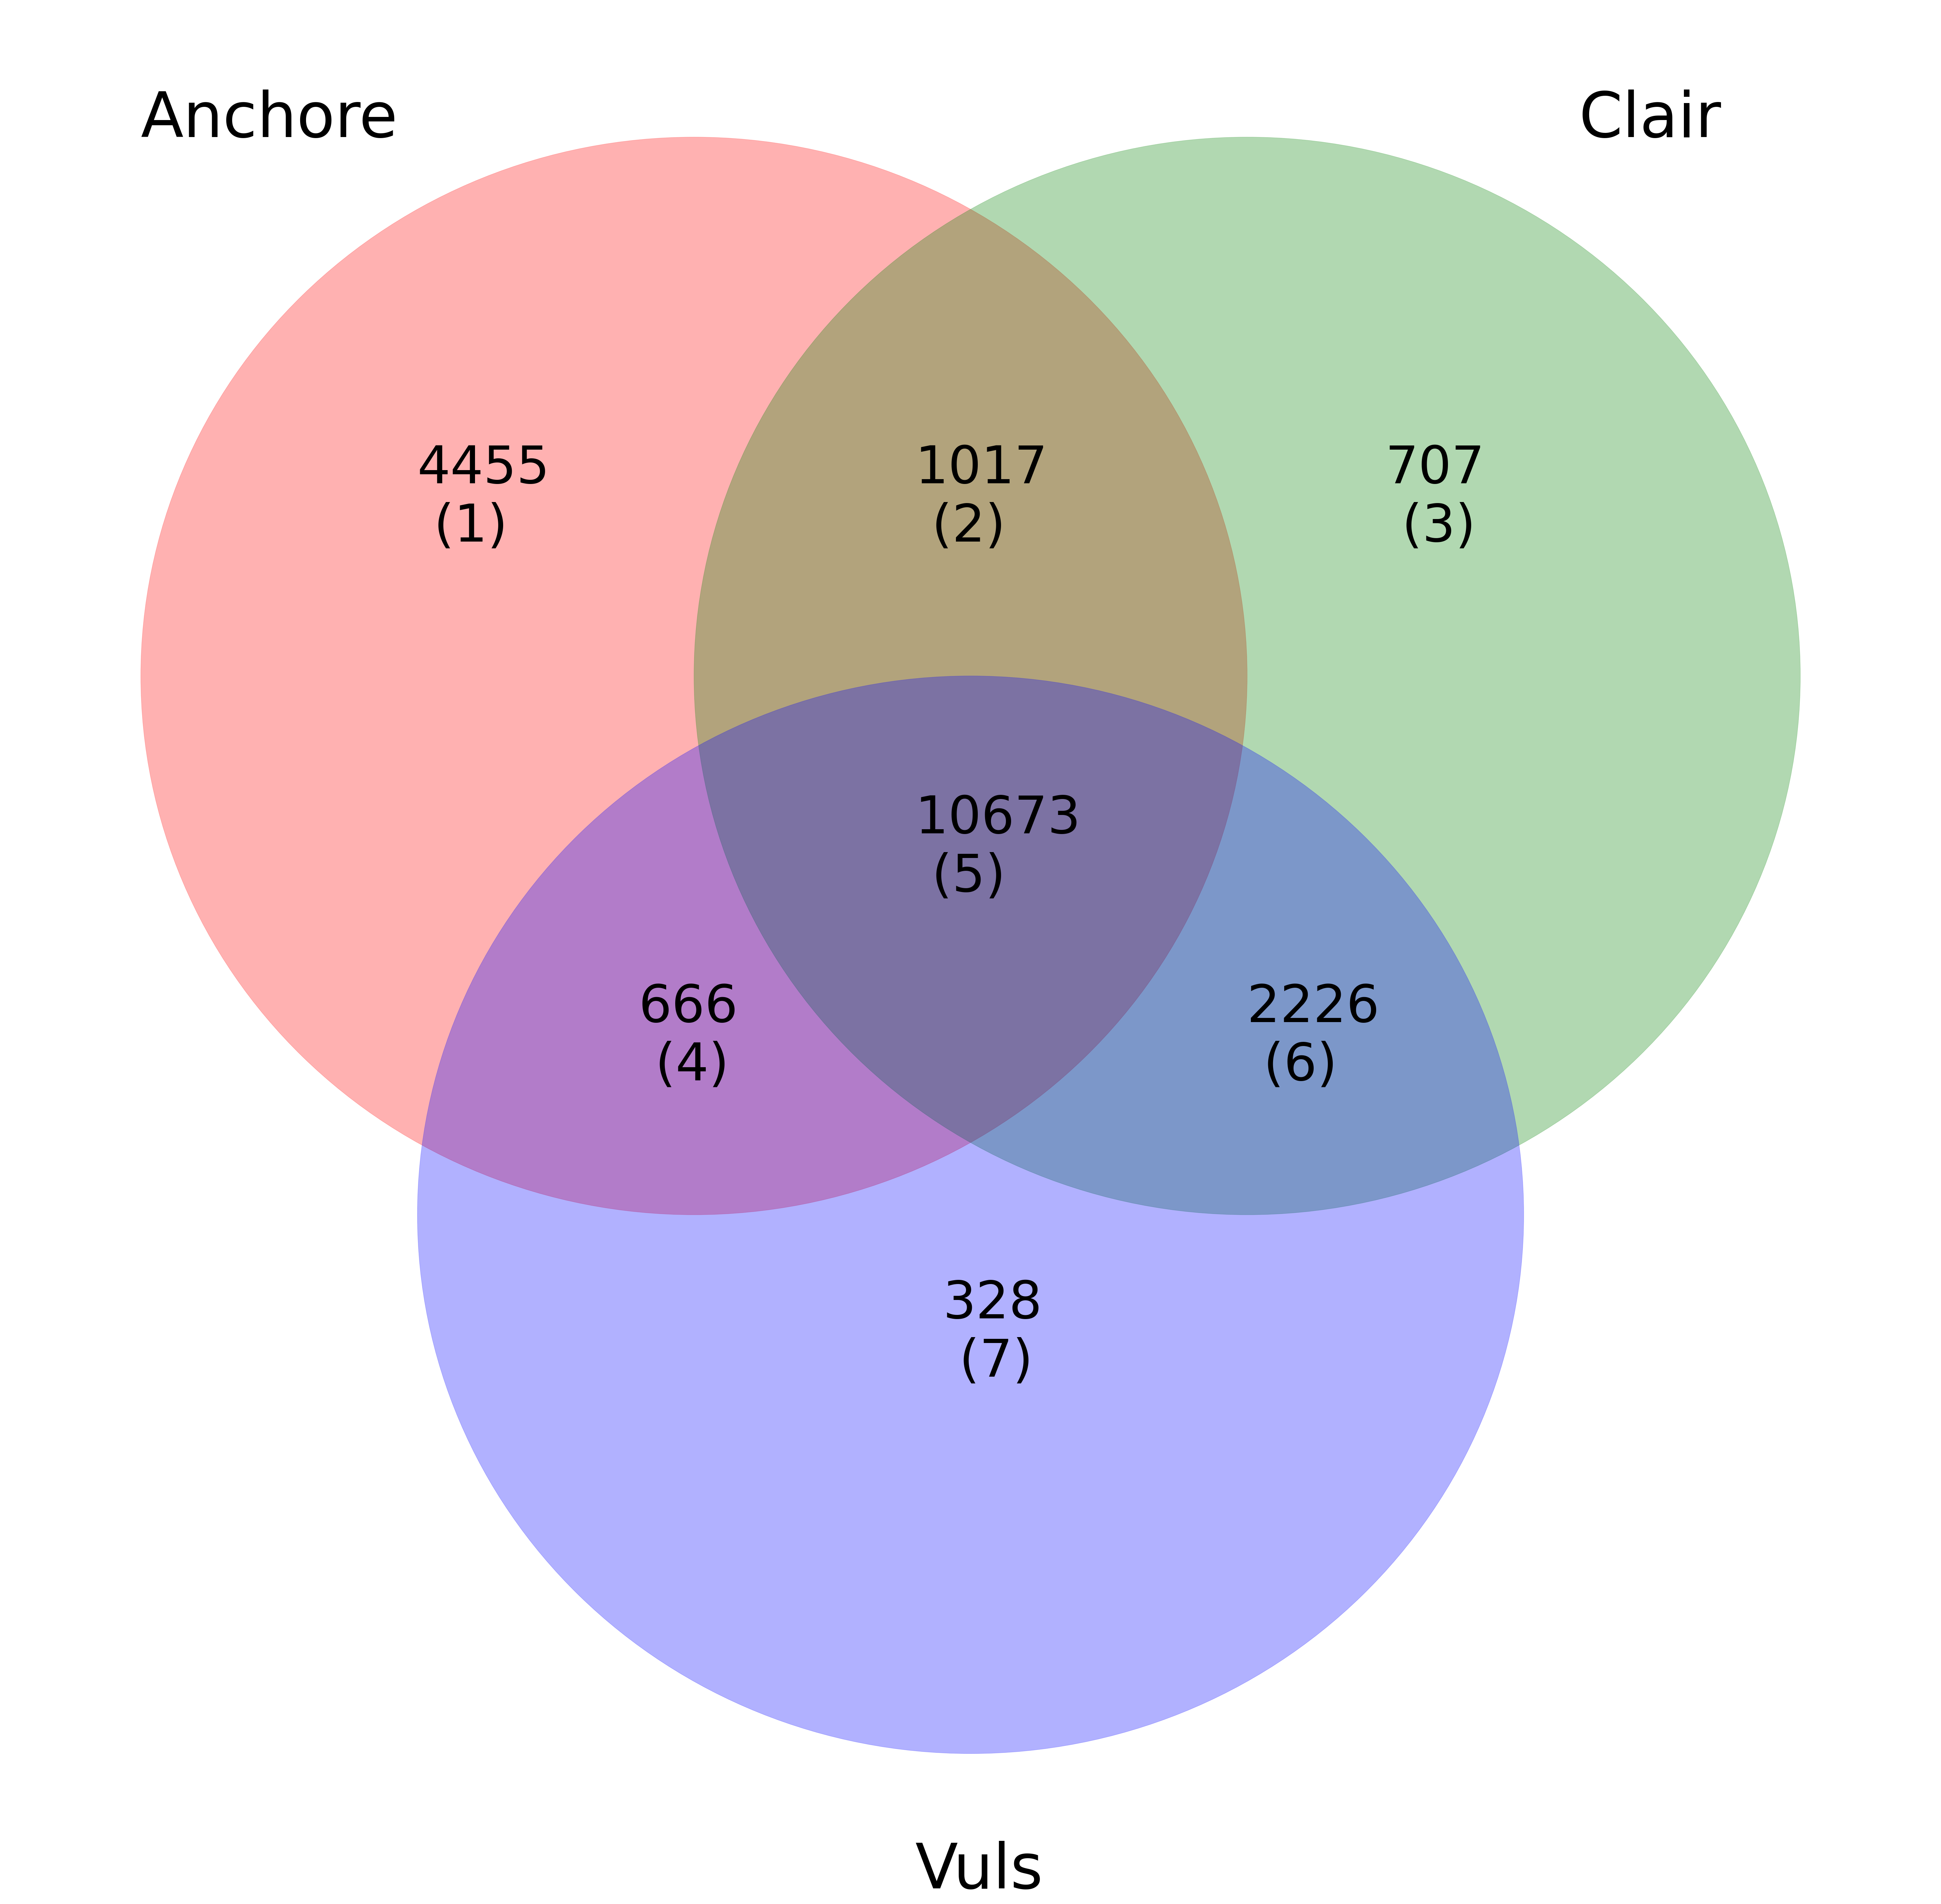

In [30]:
from matplotlib import pyplot as plt

label_size = 150
figure, axes = plt.subplots(figsize=(100,100))
alpha=0.3
anchore_circle = plt.Circle((0.4, 0.6), 0.2, alpha=alpha, color='red')
clair_circle = plt.Circle((0.6, 0.6), 0.2, alpha=alpha, color='green')
vuls_circle = plt.Circle((0.5, 0.4), 0.2, alpha=alpha, color='blue')

axes.add_artist(anchore_circle)
axes.add_artist(clair_circle)
axes.add_artist(vuls_circle)

axes.text(0.3, 0.65, str(n_r_1)+'\n (1)', color='black', fontsize=label_size)
axes.text(0.48, 0.65, str(n_r_2)+'\n (2)', color='black', fontsize=label_size)
axes.text(0.65, 0.65, str(n_r_3)+'\n (3)', color='black', fontsize=label_size)
axes.text(0.38, 0.45, str(n_r_4)+'\n (4)', color='black', fontsize=label_size)
axes.text(0.48, 0.52, str(n_r_5)+'\n (5)', color='black', fontsize=label_size)
axes.text(0.6, 0.45, str(n_r_6)+'\n (6)', color='black', fontsize=label_size)
axes.text(0.49, 0.34, str(n_r_7)+'\n (7)', color='black', fontsize=label_size)

axes.text(0.2, 0.8, 'Anchore', fontsize=1.2*label_size)
axes.text(0.72, 0.8, 'Clair', fontsize=1.2*label_size)
axes.text(0.48, 0.15, 'Vuls', fontsize=1.2*label_size)

axes.set_xlim(0.15, 0.85)
axes.set_ylim(0.15, 0.85)

axes.xaxis.set_visible(False)
axes.yaxis.set_visible(False)
axes.set_frame_on(False)

plt.savefig('./Figures/venn.pdf', bbox_inches="tight")

plt.show()

## Detailed analysis

### Preliminaries

In [31]:
# Get details about all vulnerabilities detected by Anchore
all_vulns_anchore = pd.DataFrame(columns=['Image', 'CVE', 'Package', 'Severity'])

for image in common_images:
    file_name = anchore_files[image][0]
    with open(file_name, 'r') as f:
        lines = f.readlines()
    for line in lines[1:]:
        s = shlex.split(line)
        image = d
        cve = s[0]
        package = s[1]
        severity = s[2]
        all_vulns_anchore = all_vulns_anchore.append({
            'Image': image,
            'CVE': cve,
            'Package': package,
            'Severity': severity
        }, ignore_index=True)
                

In [32]:
all_vulns_anchore

Image             CVE                                 Package  \
0      bids/niak  CVE-2018-20843                          expat-2.2.5-r0   
1      bids/niak  CVE-2019-12900                         libbz2-1.0.6-r6   
2      bids/niak  CVE-2019-14697                          musl-1.1.18-r3   
3      bids/niak  CVE-2019-14697                      musl-dev-1.1.18-r3   
4      bids/niak  CVE-2019-14697                    musl-utils-1.1.18-r3   
...          ...             ...                                     ...   
29177  bids/niak   CVE-2019-9587       libptexenc1-2015.20160222.37495-1   
29178  bids/niak   CVE-2019-9587       libsynctex1-2015.20160222.37495-1   
29179  bids/niak   CVE-2019-9587       libtexlua52-2015.20160222.37495-1   
29180  bids/niak   CVE-2019-9587     libtexluajit2-2015.20160222.37495-1   
29181  bids/niak   CVE-2019-9587  texlive-binaries-2015.20160222.37495-1   

         Severity  
0            High  
1            High  
2            High  
3            High  
4            High  
...           ...  
29177  Negligible  
29178  Negligible  
29179  Negligible  
29180  Negligible  
29181  Negligible  

[29182 rows x 4 columns]

In [ ]:
# Get details about all vulnerabilities detected by Clair
all_vulns_clair = pd.DataFrame(columns=['Image', 'CVE', 'Package', 'Severity'])
severities = [ 'Negligible', 'Low', 'Medium', 'High', 'Critical']

for image in common_images:
    file_name = clair_files[image][0]
    with open(file_name, 'r') as f:
        lines = f.readlines()
    for line in lines[1:]:
        for s in severities:
            if s in line:
                splits = line.split('|')
                cve = splits[2].replace(s, '').strip()
                package = splits[3].strip()+'-'+splits[4].strip()
                severity = s
                all_vulns_clair = all_vulns_clair.append({
                    'Image': image,
                    'CVE': cve,
                    'Package': package,
                    'Severity': severity
                }, ignore_index=True)
                continue

In [ ]:
all_vulns_clair

In [ ]:
# Get details about all vulnerabilities detected by Anchore
all_vulns_vuls = pd.DataFrame(columns=['Image', 'CVE', 'Package', 'Severity'])

for image in common_images:
    file_name = vuls_files[image][0]
    with open(file_name, 'r') as f:
        lines = f.readlines()
    for line in lines[1:]:
        cve = line.strip()
        all_vulns_vuls = all_vulns_vuls.append({
            'Image': image,
            'CVE': cve,
            'Package': None,
            'Severity': None
        }, ignore_index=True)
    print(image, file_name, len(lines))
                

In [ ]:
all_vulns_vuls

### Analysis by region of the Venn diagram

In [ ]:
def get_packages_cve_anchore(cve):
    return set(all_vulns_anchore[all_vulns_anchore['CVE'] == cve]['Package'])

def get_packages_cve_clair(cve):
    return set(all_vulns_clair[all_vulns_clair['CVE'] == cve]['Package'])

# TODO: get info about packages in Vuls

In [ ]:
# Get the set of packages in region (1) of the Venn diagram
packages = set()
for image in vuls_files:
    for cve in region_1(image):
        packages = packages.union(get_packages_cve_anchore(cve))
packages

In [ ]:
# Get the set of packages in region (2) of the Venn diagram

def get_packages_cve(cve):
    return set(all_vulns_anchore[all_vulns_anchore['CVE'] == cve]['Package'])

packages = set()
for image in vuls_files:
    for cve in region_2(image):
        packages = packages.union(get_packages_cve(cve))

packages

In [ ]:
# Get the set of packages in region (4) of the Venn diagram

def get_packages_cve(cve):
    return set(all_vulns_anchore[all_vulns_anchore['CVE'] == cve]['Package'])

packages = set()
for image in vuls_files:
    for cve in region_4(image):
        packages = packages.union(get_packages_cve(cve))

packages

In [ ]:
# Get the set of packages in region (3) of the Venn diagram

def get_packages_cve(cve):
    return set(all_vulns_clair[all_vulns_clair['CVE'] == cve]['Package'])

packages = set()
for image in vuls_files:
    for cve in region_4(image):
        packages = packages.union(get_packages_cve(cve))

packages